# Heart disease prediction

Data set source: https://www.kaggle.com/fedesoriano/heart-failure-prediction

**Attribute information:**
1. **Age**: Age of the patient [years]
2. **Sex**: Sex of the patient [M: Male, F: Female]
3. **ChestPainType**: [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. **RestingBP**: Resting blood pressure [mm Hg]
5. **Cholesterol**: Serum cholesterol [mm/dl]
6. **FastingBS**: Fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. **RestingECG**: Resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions 
    and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by 
    Estes' criteria]
8. **MaxHR**: Maximum heart rate achieved [Numeric value between 60 and 202]
9. **ExerciseAngina**: Exercise-induced angina [Y: Yes, N: No]
10. **Oldpeak**: ST [Numeric value measured in depression]
11. **ST_Slope**: The slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. **HeartDisease**: Output class [1: heart disease, 0: Normal]

The data set describes a classification problem in which we have to predict whether a person has an heart disease or not based on the above features.

---------------------------------------------------------------------------------------------------------------------

Import relevant libraries and load data:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import plotly.express as px

#importing plotly and cufflinks in offline mode
from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [2]:
# Load data
heart_disease = pd.read_csv("heart.csv")

## 1. Exploratory data analysis (EDA):

Preview of first 5 rows:

In [3]:
heart_disease.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Define the type of the features:

In [4]:
categorical_features = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope"]
continuous_features = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

Examine the shape of the data set:

In [5]:
shape = heart_disease.shape
print(f"The shape of the data is: {shape}")
print(f"Number of samples: {shape[0]}")
print(f"Number of features: {shape[1] - 1}")

The shape of the data is: (918, 12)
Number of samples: 918
Number of features: 11


Find if data contains duplicated rows:

In [6]:
print(f"Number of duplicated samples is: {heart_disease.duplicated().sum()}")

Number of duplicated samples is: 0


Check for missing values:

In [7]:
heart_disease.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

The distribution of the continuous features is as follows: 

In [8]:
heart_disease[continuous_features].iplot(kind='histogram',subplots=True,bins=50)

We can see that there are unexpected values in 'Cholesterol' and 'RestingBP', we will check the statistical description of these features to get a better understanding:

In [9]:
heart_disease.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


The minimal value of 'Cholesterol' and 'RestingBP' is 0 which is not valid, thus we'll consider it as a missing value. for that purpose we'll replace all zero values in 'Cholesterol' and 'RestingBP' to NaN:

In [10]:
cols = ["RestingBP", "Cholesterol"]
heart_disease[cols] = heart_disease[cols].replace({0:np.nan})
heart_disease.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,917.000000,746.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.540894,244.635389,0.233115,136.809368,0.887364,0.553377
std,9.432617,17.999749,59.153524,0.423046,25.460334,1.066570,0.497414
min,28.000000,80.000000,85.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,207.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,237.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,275.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Now we are able to see that the values for 'Cholesterol' and 'RestingBP' are at normal range.
In addition we can see that we now have missing values in our data set:

In [11]:
heart_disease.isnull().sum()

Age                 0
Sex                 0
ChestPainType       0
RestingBP           1
Cholesterol       172
FastingBS           0
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak             0
ST_Slope            0
HeartDisease        0
dtype: int64

To treat the missing value of 'RestingBP', we are going to remove the relevant sample:

In [12]:
heart_disease = heart_disease.dropna(subset=['RestingBP'])

We can see that the sample removal reduced the number of missing values (also in 'Cholesterol' column).

In [13]:
heart_disease.isnull().sum()

Age                 0
Sex                 0
ChestPainType       0
RestingBP           0
Cholesterol       171
FastingBS           0
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak             0
ST_Slope            0
HeartDisease        0
dtype: int64

We are now going to treat the missing values in 'Cholesterol' column. Before we do that, we'll first examine the feature's distribution:

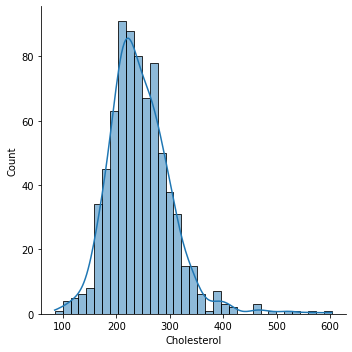

In [14]:
sns.displot(heart_disease.Cholesterol, kde= True)

We can see that the data is skewed and may contain outliers. Outliers data points will have a significant impact on the mean and hence, in such cases, it is not recommended to use the mean for replacing the missing values.When the data is skewed, it is good to consider using the median value for replacing the missing values.

In [15]:
heart_disease['Cholesterol'] = heart_disease['Cholesterol'].fillna(heart_disease['Cholesterol'].median())

In [16]:
heart_disease.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [17]:
heart_disease.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000
mean,53.509269,132.540894,243.211559,0.233370,136.789531,0.886696,0.552890
std,9.437636,17.999749,53.430044,0.423206,25.467129,1.066960,0.497466
min,28.000000,80.000000,85.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,214.000000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,237.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


### Checking target imbalance:

<AxesSubplot:xlabel='HeartDisease', ylabel='Count'>

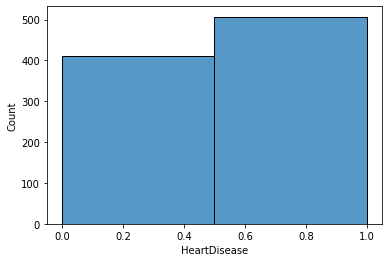

In [18]:
sns.histplot(heart_disease.HeartDisease, bins=2)

The percentage of each of the possible outputs is:

In [19]:
heart_disease['HeartDisease'].value_counts(normalize=True) * 100

1    55.288986
0    44.711014
Name: HeartDisease, dtype: float64

We can see that the data is balanced, which means that we can use 'accuracy' as our evaluation metric.

Features correlation plot:


<AxesSubplot:>

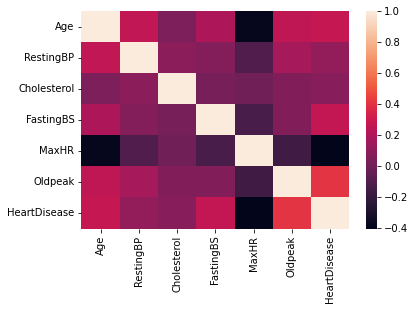

In [20]:
print("Features correlation plot:")
sns.heatmap(heart_disease.corr())

# -----------------------------TODO-----------------------------

## 2. Data preprocess:

### Outliers:

In [21]:
from scipy import stats
from scipy.stats import zscore

def outlier(feature):
    z_scores = stats.zscore(heart_disease[feature])
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3)
    return heart_disease[filtered_entries]
     
for feature in continuous_features: 
    heart_disease = outlier(feature)
heart_disease.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,53.505062,131.984252,239.748031,0.231721,136.919010,0.859168,0.546682
std,9.472710,17.169130,45.570453,0.422169,25.341456,1.004779,0.498096
min,28.000000,80.000000,85.000000,0.000000,63.000000,-2.000000,0.000000
25%,47.000000,120.000000,213.000000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,237.000000,0.000000,138.000000,0.500000,1.000000
75%,60.000000,140.000000,264.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,185.000000,394.000000,1.000000,202.000000,4.000000,1.000000


In [22]:
heart_disease.shape

(889, 12)

### Encoding Categorical Values:

In [23]:
heart_disease.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP         float64
Cholesterol       float64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

Check if all categorical features are assignd with values that they supposed to get.

In [24]:
for col in categorical_features:
    print(f"\nThe distribution of categorical valeus in '{col}' feature is:")
    print(heart_disease[col].value_counts())


The distribution of categorical valeus in 'Sex' feature is:
M    704
F    185
Name: Sex, dtype: int64

The distribution of categorical valeus in 'ChestPainType' feature is:
ASY    476
NAP    198
ATA    170
TA      45
Name: ChestPainType, dtype: int64

The distribution of categorical valeus in 'FastingBS' feature is:
0    683
1    206
Name: FastingBS, dtype: int64

The distribution of categorical valeus in 'RestingECG' feature is:
Normal    536
LVH       179
ST        174
Name: RestingECG, dtype: int64

The distribution of categorical valeus in 'ExerciseAngina' feature is:
N    529
Y    360
Name: ExerciseAngina, dtype: int64

The distribution of categorical valeus in 'ST_Slope' feature is:
Flat    443
Up      390
Down     56
Name: ST_Slope, dtype: int64


In [25]:
# heart_disease["ST_Up_slope"] = np.where(obj_df["ST_Slope"].str.contains("Up"), 1, 0)
# for later if I want to change features semantic.

Use label encoding on 'Sex', 'ExerciseAngina' and 'ST_Slope':

In [26]:
cat_to_num = {
            "Sex": {"M": 0, "F": 1},
            "ExerciseAngina": {"N": 0, "Y": 1},
            }

In [27]:
heart_disease = heart_disease.replace(cat_to_num)
heart_disease.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,0,ATA,140.0,289.0,0,Normal,172,0,0.0,Up,0
1,49,1,NAP,160.0,180.0,0,Normal,156,0,1.0,Flat,1
2,37,0,ATA,130.0,283.0,0,ST,98,0,0.0,Up,0
3,48,1,ASY,138.0,214.0,0,Normal,108,1,1.5,Flat,1
4,54,0,NAP,150.0,195.0,0,Normal,122,0,0.0,Up,0


Perform one hot encoding to 'ChestPainType' and 'RestingECG':

In [28]:
heart_disease = pd.get_dummies(heart_disease, columns=["ChestPainType", "RestingECG", "ST_Slope"], prefix=["CPT", "R_ECG", "ST_Slope"])
heart_disease.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,CPT_ASY,CPT_ATA,CPT_NAP,CPT_TA,R_ECG_LVH,R_ECG_Normal,R_ECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,0,140.0,289.0,0,172,0,0.0,0,0,1,0,0,0,1,0,0,0,1
1,49,1,160.0,180.0,0,156,0,1.0,1,0,0,1,0,0,1,0,0,1,0
2,37,0,130.0,283.0,0,98,0,0.0,0,0,1,0,0,0,0,1,0,0,1
3,48,1,138.0,214.0,0,108,1,1.5,1,1,0,0,0,0,1,0,0,1,0
4,54,0,150.0,195.0,0,122,0,0.0,0,0,0,1,0,0,1,0,0,0,1


We can see now that we no longer have non-numeric data types in our data set:

In [29]:
heart_disease.dtypes

Age                 int64
Sex                 int64
RestingBP         float64
Cholesterol       float64
FastingBS           int64
MaxHR               int64
ExerciseAngina      int64
Oldpeak           float64
HeartDisease        int64
CPT_ASY             uint8
CPT_ATA             uint8
CPT_NAP             uint8
CPT_TA              uint8
R_ECG_LVH           uint8
R_ECG_Normal        uint8
R_ECG_ST            uint8
ST_Slope_Down       uint8
ST_Slope_Flat       uint8
ST_Slope_Up         uint8
dtype: object

### Splitting dataset:

In [30]:
X = heart_disease.drop(["HeartDisease"], axis=1)
y = heart_disease["HeartDisease"]

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [32]:
print(X_train.shape)
print(X_test.shape)
#X_train_scaled.head()

(711, 18)
(178, 18)


### Feature Scaling:

In [50]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Modeling:

## Implementation of Logistic Regression (LR):

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

model = LogisticRegression(max_iter=1000, random_state=0)
model.fit(X_train_scaled, y_train)
predictions = model.predict(X_test_scaled)

accuracy_score(y_test, predictions)
# model.score(X_train_scaled, y_train)


0.8595505617977528

In [48]:
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84        77
           1       0.88      0.87      0.88       101

    accuracy                           0.86       178
   macro avg       0.86      0.86      0.86       178
weighted avg       0.86      0.86      0.86       178

[[65 12]
 [13 88]]


**Note**: It’s usually better to evaluate your model with the data you didn’t use for training. That’s how you avoid bias and detect overfitting.

* True negatives in the upper-left position
* False negatives in the lower-left position
* False positives in the upper-right position
* True positives in the lower-right position

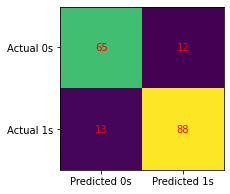

In [49]:
cm = confusion_matrix(y_test, predictions)

fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [43]:
model.score(X_train_scaled, y_train)
model.score(X_test_scaled, y_test)

0.8595505617977528

In [44]:
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [39]:
# fig = px.histogram(heart_disease, 
#                  x="HeartDisease",
#                  color="Sex",
#                  hover_data=heart_disease.columns,
#                  title="Distribution of Heart Diseases",
#                  barmode="group")
# fig.show()

# fig=px.histogram(heart_disease,
#                  x="Age",
#                  color="HeartDisease",
#                  y="Sex",
#                  hover_data=heart_disease.columns,
#                  title="Sex ratio with regard to age"
#                 )
# fig.show()

# fig=px.histogram(heart_disease,
#                  x="Sex",
#                  hover_data=heart_disease.columns,
#                  title="Sex Ratio in the Data")
# fig.show()

# fig=px.histogram(heart_disease,
#                  x="Age",
#                  color="HeartDisease",
#                  hover_data=columns,
#                  title="Sex ratio with respect to age"
#                 )
# fig.show()

# fig = px.box(heart_disease,y="Age",x="HeartDisease",title="Distrubution of Age")
# fig.show()

# fig = px.box(heart_disease,y="Age",x="HeartDisease", color="Sex", title="Distrubution of Age with respect to gender")
# fig.show()

# fig = px.box(heart_disease,y="RestingBP",x="HeartDisease",color="Sex",title="Distrubution of RestingBP with respect to gender")
# fig.show()

# fig = px.box(heart_disease,y="Cholesterol",x="HeartDisease",title="Distrubution of Cholesterol")
# fig.show()

# TODO:  Cholesterol data may contain anomalies - check that

# sns.boxplot(data=heart_disease, y='Cholesterol', x="HeartDisease")

#sns.displot(heart_disease.RestingBP)